# Chest X-Ray Classification Pipeline
This Kaggle-compatible notebook performs data preprocessing, ORB feature extraction, CNN training, and Grad-CAM visualization.

Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

BASE_DIR = "/kaggle/input/chest-x-ray-dataset/Chest_XRay_Dataset"
IMG_DIR = os.path.join(BASE_DIR, "xray_images")
CSV_PATH = os.path.join(BASE_DIR, "Ground_Truth.csv")
IMG_SIZE = (224, 224)


2025-08-07 21:07:48.165650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754600868.418557      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754600868.482091      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv(CSV_PATH)
df['Exists'] = df['Image Index'].apply(lambda x: os.path.exists(os.path.join(IMG_DIR, x)))
df = df[df['Exists']].copy()
df.drop(columns=["Exists"], inplace=True)

def get_classes(df):
    all_labels = df["Finding Labels"].str.split("|").explode().unique()
    return sorted([l for l in all_labels if isinstance(l, str)])

CLASSES = get_classes(df)
print(f"Classes ({len(CLASSES)}):", CLASSES)


Classes (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Preprocessing Function: Applies following transformations

* Resizing to 224×224 pixels
* Adding Gaussian noise to simulate real-world imaging noise
* Random rotation for orientation robustness
* Perspective transformation to simulate viewpoint changes
* Histogram equalization in YCrCb color space for contrast enhancement

In [3]:
def preprocess_image(img_path, visualize=False):
    steps = []
    titles = []

    # Load original
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    steps.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    titles.append("Original")

    # Gaussian Noise
    noise = np.random.normal(0, 15, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)
    steps.append(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))
    titles.append("After Gaussian Noise")

    # Rotation
    M = cv2.getRotationMatrix2D((112, 112), np.random.randint(-15, 15), 1)
    rotated_img = cv2.warpAffine(noisy_img, M, IMG_SIZE)
    steps.append(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
    titles.append("After Rotation")

    # Perspective Transform
    pts1 = np.float32([[0,0],[224,0],[0,224],[224,224]])
    delta = 20
    pts2 = np.float32([
        [np.random.randint(0, delta), np.random.randint(0, delta)],
        [224 - np.random.randint(0, delta), np.random.randint(0, delta)],
        [np.random.randint(0, delta), 224 - np.random.randint(0, delta)],
        [224 - np.random.randint(0, delta), 224 - np.random.randint(0, delta)]
    ])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    warped_img = cv2.warpPerspective(rotated_img, matrix, IMG_SIZE)
    steps.append(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    titles.append("After Perspective Transform")

    # Histogram Equalization
    ycrcb = cv2.cvtColor(warped_img, cv2.COLOR_BGR2YCrCb)
    ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
    equalized_img = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    steps.append(equalized_img)
    titles.append("After Histogram Equalization")

    if visualize:
        plt.figure(figsize=(18, 4))
        for i, (img, title) in enumerate(zip(steps, titles)):
            plt.subplot(1, len(steps), i+1)
            plt.imshow(img)
            plt.title(title)
            plt.axis("off")
        plt.tight_layout()
        plt.show()


Example of visualization steps

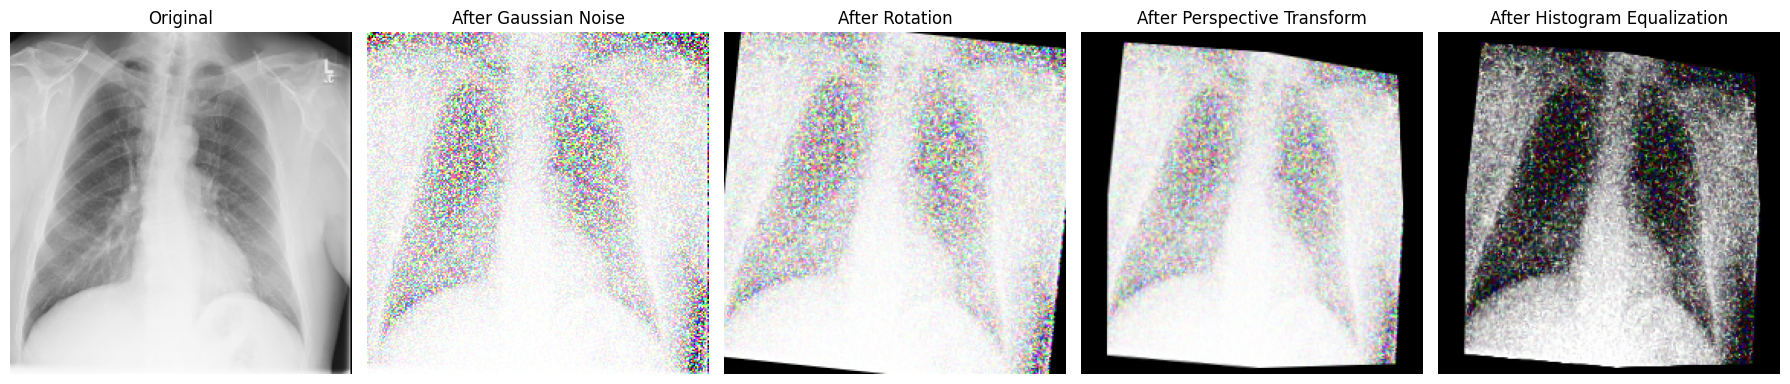

In [4]:
import random

sample_path = random.choice(glob(os.path.join(IMG_DIR, "*.png")))  # or use "*.jpg" if needed
preprocess_image(sample_path, visualize=True)

ORB Feature Extraction

Purpose: Extracts keypoint-based handcrafted features from X-ray images to complement deep CNN features in a hybrid model.

What it does: Detects ORB descriptors, flattens them, and pads/truncates to a fixed size (5000) for consistent classical feature representation.

In [5]:
orb = cv2.ORB_create()

def extract_orb_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
        
    img = cv2.resize(img, IMG_SIZE)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    
    return descriptors

def extract_orb_flattened(df):
    orb_features = []
    for fname in tqdm(df["Image Index"], desc="Extracting ORB"):
        path = os.path.join(IMG_DIR, fname)
        desc = extract_orb_features(path)
        
        if desc is not None:
            desc = desc.flatten()
            if desc.shape[0] < 5000:
                padded = np.zeros(5000)
                padded[:desc.shape[0]] = desc
                desc = padded
            else:
                desc = desc[:5000]
            orb_features.append(desc)
        else:
            orb_features.append(np.zeros(5000))  
    return np.array(orb_features)


Dataset Splitting & Loading

Purpose: Splits the dataset into training, validation, and test sets, and prepares the corresponding image-label pairs for model training.

What it does: Loads preprocessed images and encodes multi-label disease annotations into binary format for each of the 15 classes.

In [6]:
from tqdm import tqdm  

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

def prepare_labels(df, classes):
    y = np.zeros((len(df), len(classes)))
    for i, labels in enumerate(df["Finding Labels"]):
        for label in labels.split("|"):
            if label in classes:
                y[i, classes.index(label)] = 1
    return y

def load_images(df):
    images = []
    for fname in tqdm(df["Image Index"], desc="Loading images"):
        path = os.path.join(IMG_DIR, fname)
        img = preprocess_image(path)
        if img is not None:
            images.append(img)
        else:
            images.append(np.zeros((224, 224, 3)))  # fallback to avoid shape mismatch
    return np.array(images)

X_train, y_train = load_images(df_train), prepare_labels(df_train, CLASSES)
X_val, y_val = load_images(df_val), prepare_labels(df_val, CLASSES)
X_test, y_test = load_images(df_test), prepare_labels(df_test, CLASSES)

Loading images: 100%|██████████| 369/369 [00:11<00:00, 32.30it/s]


In [7]:
orb_features_train = extract_orb_flattened(df_train)
orb_features_test = extract_orb_flattened(df_test)

Extracting ORB: 100%|██████████| 369/369 [00:06<00:00, 60.59it/s]


Oversampling: Balancing Multi-Label Training Data

Why required: Handles class imbalance in the dataset where some diseases are underrepresented, which can cause the model to ignore rare classes.

What it does: Oversamples each class to match the frequency of the most common class, ensuring that the model is equally exposed to all disease labels during training.

In [8]:
# NOTE: Skipping this part because of memory limitation


# def balance_multilabel_data(X, y):
#     class_counts = np.sum(y, axis=0)
#     max_count = int(np.max(class_counts))

#     X_balanced = []
#     y_balanced = []

#     for class_idx in range(len(CLASSES)):
#         indices = [i for i in range(len(y)) if y[i][class_idx] == 1]
#         if not indices:
#             continue

#         repeat_factor = int(np.ceil(max_count / len(indices)))
#         sampled_indices = np.tile(indices, repeat_factor)[:max_count]

#         for i in sampled_indices:
#             X_balanced.append(X[i])
#             y_balanced.append(y[i])

#     return np.array(X_balanced), np.array(y_balanced)

# X_train, y_train = balance_multilabel_data(X_train, y_train)

CNN Model using EfficientNetB0 (Transfer Learning)

* We use EfficientNetB0 as the backbone CNN, pre-trained on ImageNet, and add global average pooling followed by a dense output layer for multi-label classification.

* Early layers are frozen to leverage pre-trained features, and EarlyStopping is used to avoid overfitting. Memory growth is also enabled for GPUs to reduce memory allocation errors.

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

input_tensor = Input(shape=(224, 224, 3))
cnn_base = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=input_tensor)

x = GlobalAveragePooling2D()(cnn_base.output)
output = Dense(len(CLASSES), activation="sigmoid")(x)

cnn_model = Model(inputs=cnn_base.input, outputs=output)

# Freeze early layers for transfer learning
for layer in cnn_base.layers[:-10]:
    layer.trainable = False

cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

Trains the CNN model on balanced data with early stopping to prevent overfitting.

In [10]:
# history = cnn_model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=10,
#     batch_size=32,
#     callbacks=[early_stop],
#     verbose=1
# )

Extracts intermediate CNN features from the trained model for both training and test images to use in the hybrid model.

In [11]:
cnn_feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X, batch_size=32):
        self.X = X
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size : (idx + 1) * self.batch_size]
        return np.array(batch_x)

train_gen = DataGenerator(X_train, batch_size=16)
test_gen = DataGenerator(X_test, batch_size=16)

# Predict in batches for avoid Out of Memory issue
cnn_features_train = cnn_feature_extractor.predict(X_train, verbose=1)
cnn_features_test = cnn_feature_extractor.predict(X_test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


Combines CNN and ORB features to form hybrid feature vectors for training and testing the final model.

In [12]:
X_train_hybrid = np.concatenate([cnn_features_train, orb_features_train], axis=1)
X_test_hybrid = np.concatenate([cnn_features_test, orb_features_test], axis=1)

Hybrid Model Training with XGBoost

Purpose: This block trains a hybrid model by combining CNN and ORB features using a multi-output XGBoost classifier to handle the multilabel classification task.

What It Does: It fits the model on the hybrid feature vectors and evaluates performance on the test set using standard classification metrics.

In [ ]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

xgb_base = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

hybrid_model = MultiOutputClassifier(xgb_base)
hybrid_model.fit(X_train_hybrid, y_train)

hybrid_preds = hybrid_model.predict(X_test_hybrid)

print("Hybrid XGBoost Model Evaluation:")
print(classification_report(y_test, hybrid_preds, target_names=CLASSES))

Hybrid XGBoost Model Evaluation:
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00        33
      Cardiomegaly       0.00      0.00      0.00        16
     Consolidation       0.00      0.00      0.00        17
             Edema       0.00      0.00      0.00         4
          Effusion       0.00      0.00      0.00        29
         Emphysema       0.00      0.00      0.00         4
          Fibrosis       0.00      0.00      0.00        14
            Hernia       0.00      0.00      0.00         2
      Infiltration       0.50      0.01      0.03        74
              Mass       0.00      0.00      0.00        14
        No Finding       0.56      0.80      0.66       200
            Nodule       0.00      0.00      0.00        20
Pleural_Thickening       0.00      0.00      0.00        12
         Pneumonia       0.00      0.00      0.00         4
      Pneumothorax       0.00      0.00      0.00        11

     

Grad-CAM Visualization

Purpose: This function helps us visualize which parts of an image the CNN model focuses on when making predictions. It's especially useful in medical imaging to interpret model decisions.

Steps Performed:

1. Computes the gradients of the predicted class with respect to a convolutional layer.
2. Generates a heatmap using weighted feature maps.
3. Overlays the heatmap on the original image for intuitive understanding.

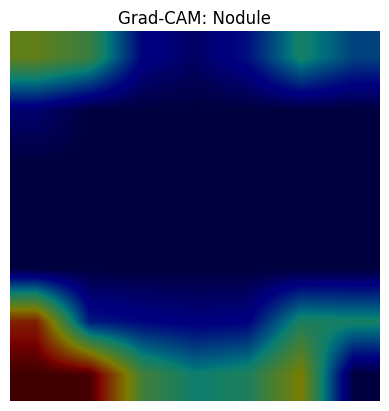

In [14]:
def grad_cam_visualize(model, img_array, class_index, layer_name='top_activation'):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img_array]))
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()  # ✅ move here

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-5)

    plt.imshow(img_array.astype(np.uint8))
    plt.imshow(cv2.resize(heatmap, IMG_SIZE), cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f"Grad-CAM: {CLASSES[class_index]}")
    plt.show()

example_idx = 8
example_class = np.argmax(y_test[example_idx])

grad_cam_visualize(cnn_model, X_test[example_idx], class_index=example_class)

ROC Curve Visualization

Purpose: Evaluate the performance of the hybrid model across each disease class using Receiver Operating Characteristic (ROC) curves.

What It Does:

* Computes True Positive Rate (TPR) and False Positive Rate (FPR) for each class.

* Plots the ROC curves and computes the Area Under the Curve (AUC) to measure how well the model distinguishes between classes.

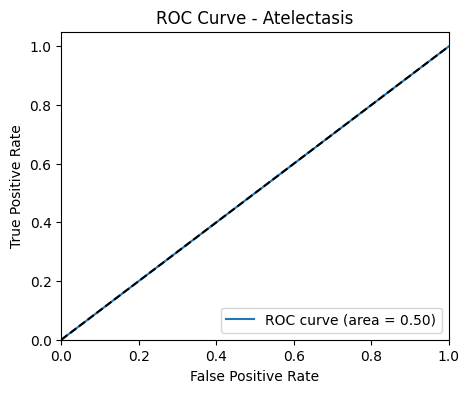

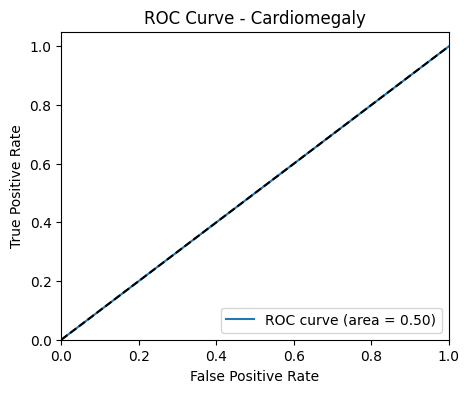

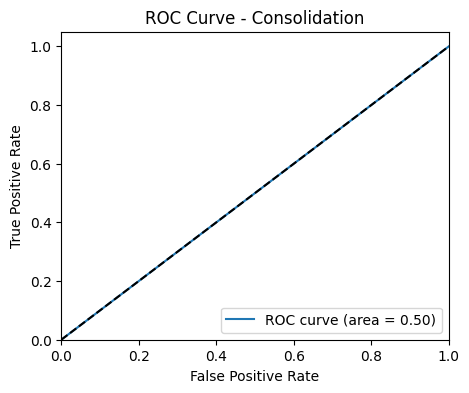

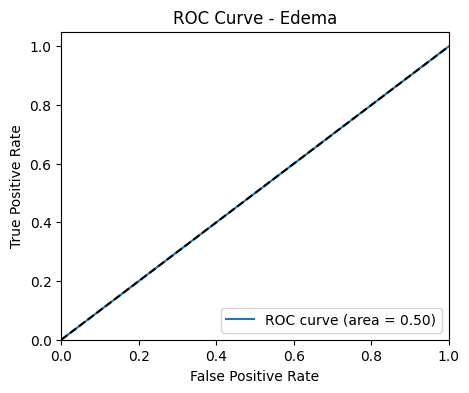

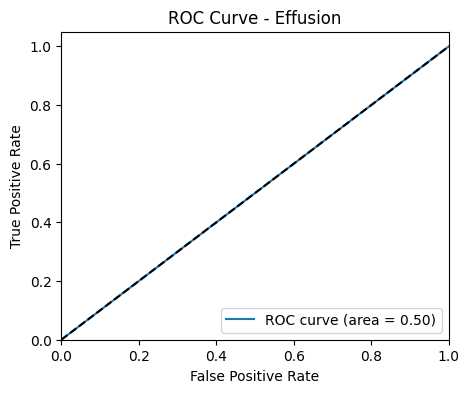

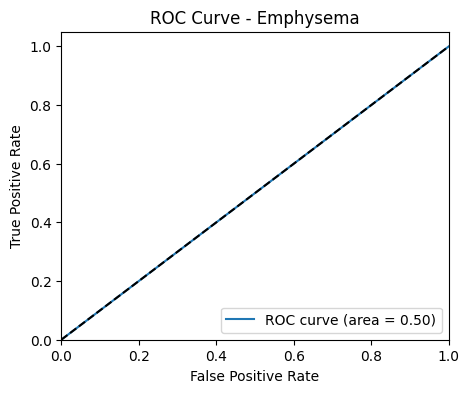

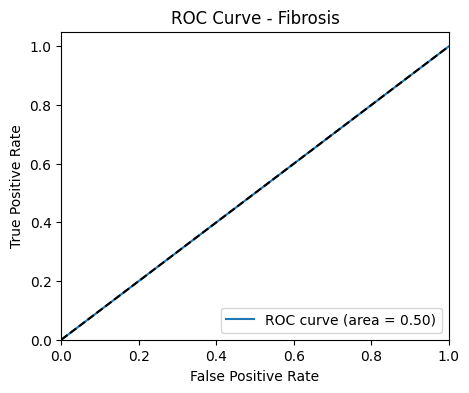

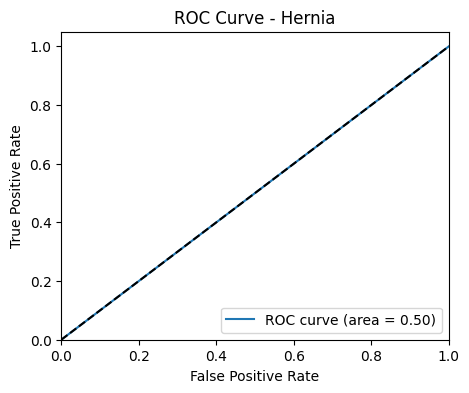

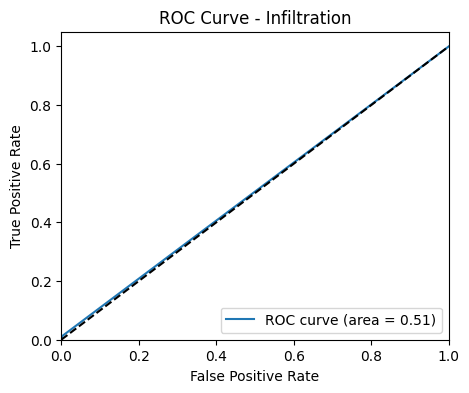

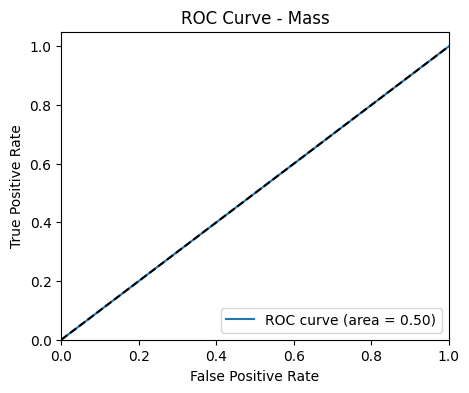

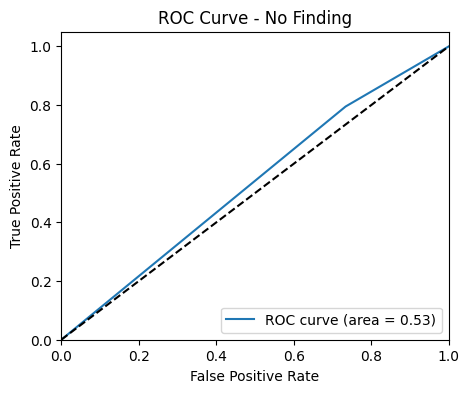

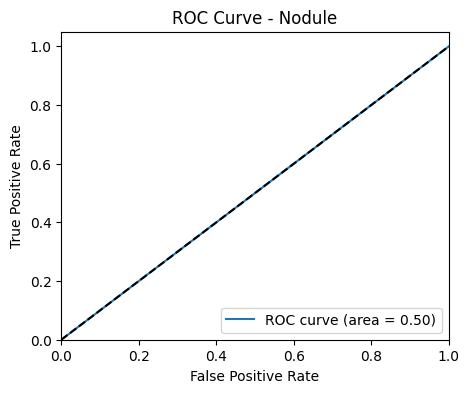

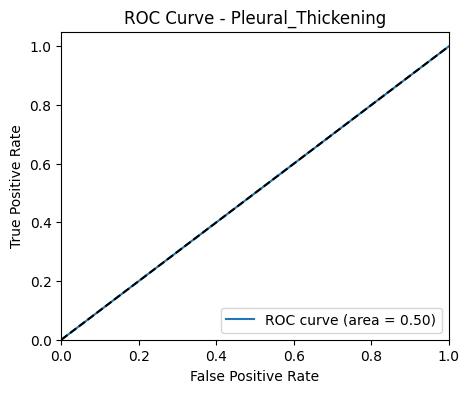

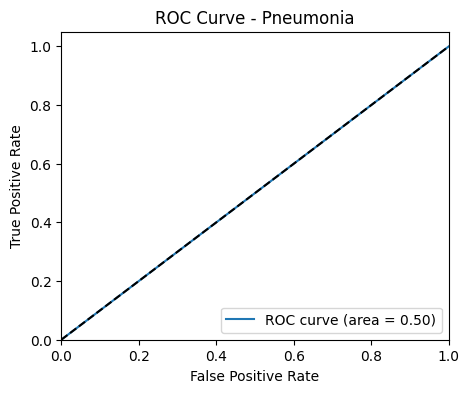

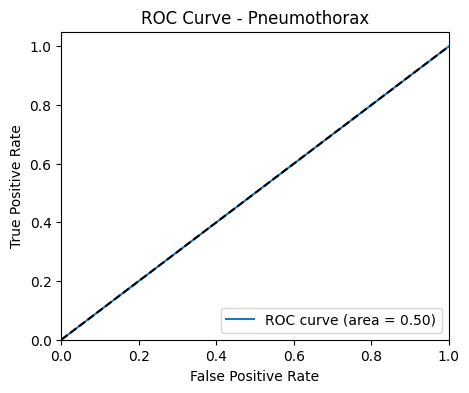

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

# Ensure predictions are binary numpy array
hybrid_preds = np.array(hybrid_preds)

for i in range(len(CLASSES)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], hybrid_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot a few example ROC curves
for i in range(len(CLASSES)):
    plt.figure(figsize=(5, 4))
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {CLASSES[i]}')
    plt.legend(loc="lower right")
    plt.show()

Saving Trained Models and Scalers: Persisting the trained hybrid model and scalers using joblib for future inference and reproducibility.

In [16]:
import joblib

joblib.dump(hybrid_model, "hybrid_xgb_model.pkl")

joblib.dump(cnn_model, "cnn_model.pkl")

['cnn_model.pkl']